In [82]:
from PIL import Image
import os
import cv2

import torch.tensor as tensor
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import random_split as random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import time

In [83]:
torch.cuda.is_available()

True

In [84]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [85]:
width, height= 224,224
batch_size=32
learning_rate=0.001

In [86]:
train_dir='Training'
test_dir='Testing'

In [87]:
num_classes=len(os.listdir(train_dir))
num_classes

4

In [88]:
# Tensor 변환, 이미지 input size 맞춰주기 등 input data에 대한 전처리
image_transforms={
    'train':transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((width, height)),    
            transforms.RandomRotation(0.2),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])  
    ]),
    'test':transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((width, height)),    
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
    ])
}


#data 직접 가져와서 transform
data={
    'train':datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'test':datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

In [89]:
train_data_loader=DataLoader(data['train'], batch_size=batch_size, shuffle=True)
test_data_loader=DataLoader(data['test'], batch_size=batch_size, shuffle=False)

In [90]:
# len_train=len(data['train'])
len_train=len(data['train'])
len_test=len(data['test'])
print('length of train_data: ',len(data['train']))
print('length of test_data: ',len(data['test']))

length of train_data:  2871
length of test_data:  394


In [94]:
for dir in ['/glioma_tumor', '/meningioma_tumor', '/no_tumor', '/pituitary_tumor']:
    print(dir , ':', len(os.listdir(train_dir+dir)))

/glioma_tumor : 827
/meningioma_tumor : 822
/no_tumor : 395
/pituitary_tumor : 827


In [95]:
indexes={k:v for k,v in data['train'].class_to_idx.items()}
print(indexes)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
<class 'numpy.ndarray'>


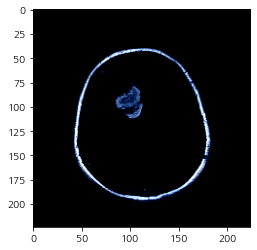

In [96]:
#이미지 보기
for batch_idx, (inputs, targets) in enumerate(train_data_loader):
    if batch_idx==1:
        break
    else:
        print(batch_idx)
        img=inputs[batch_idx].numpy()
        print(type(img))
        plt.imshow(np.transpose(img,(1,2,0)))
        plt.show()

In [97]:
print(img.shape)
print(type(img))
print(np.transpose(img,(1,2,0)).shape)

(3, 224, 224)
<class 'numpy.ndarray'>
(224, 224, 3)


In [98]:
# base_model=models.resnet50(pretrained=True)
base_model=models.vgg16_bn(pretrained=True)

for param in base_model.parameters():
    param.requires_grad=True
    param.requires_bias=True

n_inputs=base_model.classifier[-1].in_features
last_layer=nn.Linear(n_inputs, 4)
base_model.classifier[-1]=last_layer

base_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [49]:
from torchsummary import summary
summary(base_model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [99]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(base_model.parameters(), lr=0.001)

In [100]:
def train(model, loss, optimizer, epochs):
    start=time.time()
    history=[]
    best_acc=0.0
    
    for epoch in range(epochs):
        epoch_start=time.time()
        print('Epoch : {} / {}' .format(epoch+1, epochs))

        model.train()

        train_loss=0.0
        train_acc=0.0

        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)

            loss=criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss+=loss.item() * inputs.size(0)

            ret, predictions=torch.max(outputs.data,1)
            correct_counts=predictions.eq(labels.data.view_as(predictions))

            acc=torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc+=acc.item() * inputs.size(0)
            
    
        avg_train_loss=train_loss/len_train
        avg_train_acc=train_acc/len_train
        print('Training : loss - {:.4f}, Accuracy - {:4f}'.format(avg_train_loss, avg_train_acc))
        history.append([avg_train_loss, avg_train_acc])
        
        
    
        
    epoch_end=time.time()
    print("Epoch :{:03d} , Validation: loss - {:.4f}, Accuracy - {:4f}, Time : {:4f}s"\
          .format(epoch+1, avg_train_loss, (avg_train_acc)*100, epoch_end-epoch_start))
    
#     torch.save(model.state_dict(), '/models')
#     torch.save('model_2', '/models')
    
    return model, history


In [101]:
epochs=30
train_model, train_history=train(base_model, criterion, optimizer, epochs)

Epoch : 1 / 30
Training : loss - 0.8257, Accuracy - 0.692442
Epoch : 2 / 30
Training : loss - 0.5942, Accuracy - 0.776733
Epoch : 3 / 30
Training : loss - 0.5175, Accuracy - 0.800766
Epoch : 4 / 30
Training : loss - 0.4760, Accuracy - 0.819227
Epoch : 5 / 30
Training : loss - 0.4280, Accuracy - 0.836294
Epoch : 6 / 30
Training : loss - 0.4548, Accuracy - 0.822710
Epoch : 7 / 30
Training : loss - 0.3679, Accuracy - 0.859282
Epoch : 8 / 30
Training : loss - 0.4519, Accuracy - 0.857541
Epoch : 9 / 30
Training : loss - 0.3906, Accuracy - 0.868339
Epoch : 10 / 30
Training : loss - 0.4016, Accuracy - 0.864855
Epoch : 11 / 30
Training : loss - 0.2504, Accuracy - 0.912226
Epoch : 12 / 30
Training : loss - 0.2027, Accuracy - 0.930686
Epoch : 13 / 30
Training : loss - 0.1465, Accuracy - 0.946012
Epoch : 14 / 30
Training : loss - 0.1450, Accuracy - 0.949495
Epoch : 15 / 30
Training : loss - 0.2585, Accuracy - 0.922675
Epoch : 16 / 30
Training : loss - 0.2403, Accuracy - 0.932428
Epoch : 17 / 30
T

In [102]:
train_model.eval()
correct=0
total=0

with torch.no_grad(): #test니까 gradient update 없음
    for images , labels in test_data_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs=train_model(images)
        _, predicted= torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print('Test Accuracy {} %'.format(round(100*correct/total , 6)))

Test Accuracy 70.558376 %


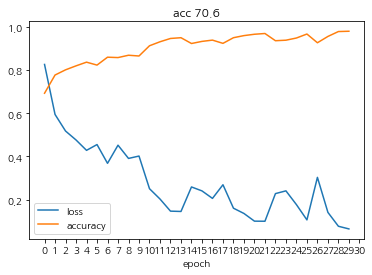

In [103]:
plt.subplots
history=np.array(train_history)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.legend(['loss', 'accuracy'])
plt.xticks(np.arange(0,epochs+1))
plt.xlabel('epoch')
plt.title('acc 70.6')
plt.rcParams['axes.unicode_minus'] = False  
plt.savefig('vgg16_bn_second.png')
plt.show()